In [3]:
import numpy as np
import pandas as pd
np.random.seed(0)

### Домашнее задание 2. 
#### Источник кода с комментариями : http://blog.ethanrosenthal.com/2016/01/09/explicit-matrix-factorization-sgd-als/
#### 1. Сравнить качество рекоменадций и время выполнения ALS (без базовых предикторов - without biases) и SGD (без базовых предикторов) для различных параметров регуляризации (например, 0,001, 0,01,...)  и числа факторов (например, 1, 10, 25, 50,...). Для SGD необходимо усовершенствовать код.

#### 2. Исправить код ALS  так, чтобы была возможность производить рассчеты с базовыми предикторами (biases). Неплохая инструкция тут: http://activisiongamescience.github.io/2016/01/11/Implicit-Recommender-Systems-Biased-Matrix-Factorization/.

#### 3. Cравнить все 4 подхода по мере MSE, времени на обучение (training phase) и тестирование (inference phase). Результаты, помимо шагов выполнения в ipython, необходимо представить в сводной таблице. 

#### Источник данных: MovieLens 100k. Может быть выбран альтернативный, но не меньший по числу оценок, либо пользователей и предметов (items).

#### Отчеты присылаются на dmitrii.ignatov@gmail.com с обязательной копией на egurnovdima@gmail.com. Тема письма: [RecSys2018-FinTech-HW2]-Фамилия_Имя.

#### Deadline: 15.12.2018

In [2]:
cd ml-100k/

[Error 2] : u'ml-100k/'
C:\Users\Administrator\Dropbox\MLDM Course\Рекомендательные системы\MF scripts\ml-100k


### Загружаем оценки и собираем из них матрицу оценок $r_{ij}$ 

In [10]:
# загружаем данные.
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

# Создаем r_{ui} - нашу матрицу оценок
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

### Функция, которая делит множество оценок на test и train

In [11]:
# Делим данные на train и test 
# Для каждого пользователя 10 случайных оценок отправляем в test
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in np.arange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Проверяем, что   t est и train не пересекаются
    assert(np.all((train * test) == 0)) 
    return train, test

### Метрика качества

In [12]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

### Класс, которые реализует алгоритм ALS и ExplicitMF c градиентным спуском и смещениями

In [13]:
from numpy.linalg import solve


class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter,0)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter,0)
    
    
    def partial_train(self, n_iter, iter_done):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if (ctr+iter_done) % 10 == 0 and self._v:
                print (f'\tcurrent iteration: {ctr+iter_done}')
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate *\
                                    (e * self.item_vecs[i, :] - self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print (f'Iteration: {n_iter}')
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff, iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print (f'MSE train:test: {round(self.train_mse[-1],2)} : {round(self.test_mse[-1],2)}\n')
            iter_diff = n_iter

#### для построения графиков

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=3)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=3)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('Iterations', fontsize=25);
    plt.ylabel('MSE', fontsize=25);
    plt.legend(loc='best', fontsize=20);

##### Градиентный спуск с базовыми предикторами (biases)

In [15]:
train, test = train_test_split(ratings)
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]

In [16]:
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
MSE train:test: 1.14 : 1.19

Iteration: 2
MSE train:test: 1.07 : 1.14

Iteration: 5
MSE train:test: 0.98 : 1.06

Iteration: 10
	current iteration: 10
MSE train:test: 0.92 : 1.01

Iteration: 25
	current iteration: 20
MSE train:test: 0.87 : 0.96

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:test: 0.84 : 0.94

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:test: 0.75 : 0.92

Iteration: 200
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
	current iteration: 200
MSE train:test: 0.4 : 0.92



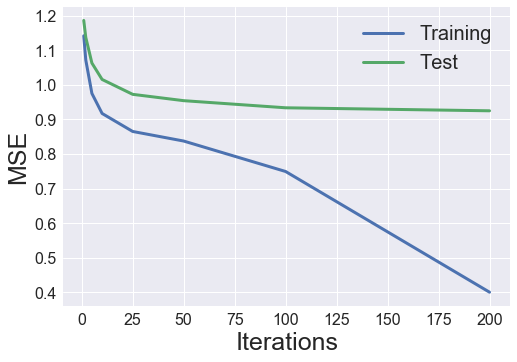

In [12]:
plot_learning_curve(iter_array, MF_SGD)

#### ALS без базовых предикторов

In [17]:
MF_ALS = ExplicitMF(train, 40, learning='als', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_ALS.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
MSE train:test: 5.52 : 9.93

Iteration: 2
MSE train:test: 4.21 : 8.66

Iteration: 5
MSE train:test: 3.97 : 8.5

Iteration: 10
	current iteration: 10
MSE train:test: 3.93 : 8.48

Iteration: 25
	current iteration: 20
MSE train:test: 3.92 : 8.47

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:test: 3.92 : 8.48

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:test: 3.92 : 8.48

Iteration: 200
	current iteration: 110
	current iteration: 120
	current iteration: 130
	current iteration: 140
	current iteration: 150
	current iteration: 160
	current iteration: 170
	current iteration: 180
	current iteration: 190
	current iteration: 200
MSE train:test: 3.92 : 8.47



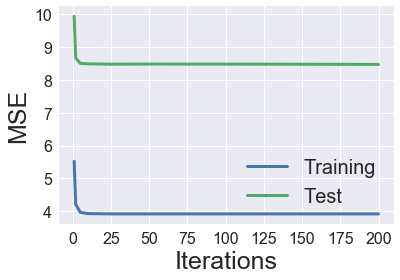

In [18]:

plot_learning_curve(iter_array, MF_ALS)